# Image Caption Generator - Deep Learning Project

**Project Goal:** Generate natural language descriptions for images using Deep Learning

**Dataset:** Flickr8k (8,000 images with 5 captions each)

**Environment:** Google Colab with Google Drive integration

---

## Deep Learning Life Cycle Phases:

1. **Problem Definition & Setup**
2. **Data Gathering & Preprocessing**
3. **Model Architecture Selection**
4. **Training & Tuning**
5. **Evaluation**
6. **Deployment (GUI)**

---

# Phase 1: Problem Definition & Setup

## Problem Statement

Image captioning combines **Computer Vision** and **Natural Language Processing**. We'll use an **Encoder-Decoder architecture**:

- **Encoder (CNN)**: Extracts visual features from images using InceptionV3
- **Decoder (LSTM)**: Generates captions word-by-word based on visual features

## Setup Environment

In [ ]:
# Import necessary libraries
import os
import re-----------------------------------
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import pickle

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add, BatchNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Mount Google Drive to access Flickr8k dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configure dataset paths
BASE_PATH = '/content/drive/MyDrive/Flicker8k_Dataset/'
IMAGES_PATH = os.path.join(BASE_PATH, 'Flicker8k_images')
TEXT_PATH = os.path.join(BASE_PATH, 'Flickr8k_text')
CAPTIONS_FILE = os.path.join(TEXT_PATH, 'Flickr8k.token.txt')
TRAIN_IMAGES_FILE = os.path.join(TEXT_PATH, 'Flickr_8k.trainImages.txt')
DEV_IMAGES_FILE = os.path.join(TEXT_PATH, 'Flickr_8k.devImages.txt')
TEST_IMAGES_FILE = os.path.join(TEXT_PATH, 'Flickr_8k.testImages.txt')
MODEL_SAVE_PATH = '/content/drive/MyDrive/best_model.keras'

# Verify paths exist
print(f"Dataset path: {BASE_PATH}")
print(f"Images path exists: {os.path.exists(IMAGES_PATH)}")
print(f"Text path exists: {os.path.exists(TEXT_PATH)}")
print(f"Captions file exists: {os.path.exists(CAPTIONS_FILE)}")

if os.path.exists(IMAGES_PATH):
    num_images = len([f for f in os.listdir(IMAGES_PATH) if f.endswith(('.jpg', '.png', '.jpeg'))])
    print(f"Number of images found: {num_images}")

Dataset path: /content/drive/MyDrive/Flicker8k_Dataset/
Images path exists: True
Text path exists: True
Captions file exists: True
Number of images found: 8091


---

# Phase 2: Data Gathering & Preprocessing

This phase involves:
1. **Loading captions** from Flickr8k.token.txt (format: image_name#index\tcaption)
2. **Text cleaning**: Lowercase, remove punctuation/numbers, add tokens
3. **Tokenization**: Build vocabulary and map words to integers
4. **Image preprocessing**: Extract features using InceptionV3
5. **Dataset splitting**: Use official train/dev/test split files

## 2.1 Load Captions

In [ ]:
def load_captions(filepath):

    captions_dict = {}

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # Split by tab
            parts = line.split('\t')
            if len(parts) != 2:
                continue

            # Extract image name (remove #caption_index)
            image_caption_id = parts[0]
            caption = parts[1]

            # Get image name without caption index
            image_id = image_caption_id.split('#')[0]

            if image_id not in captions_dict:
                captions_dict[image_id] = []

            captions_dict[image_id].append(caption)

    return captions_dict

# Load the captions
all_captions = load_captions(CAPTIONS_FILE)

print(f"Total images with captions: {len(all_captions)}")
print(f"\nSample (first 3 images):")
for i, (img_id, caps) in enumerate(list(all_captions.items())[:3]):
    print(f"\n{img_id}:")
    for cap in caps:
        print(f"  - {cap}")

Total images with captions: 8092

Sample (first 3 images):

1000268201_693b08cb0e.jpg:
  - A child in a pink dress is climbing up a set of stairs in an entry way .
  - A girl going into a wooden building .
  - A little girl climbing into a wooden playhouse .
  - A little girl climbing the stairs to her playhouse .
  - A little girl in a pink dress going into a wooden cabin .

1001773457_577c3a7d70.jpg:
  - A black dog and a spotted dog are fighting
  - A black dog and a tri-colored dog playing with each other on the road .
  - A black dog and a white dog with brown spots are staring at each other in the street .
  - Two dogs of different breeds looking at each other on the road .
  - Two dogs on pavement moving toward each other .

1002674143_1b742ab4b8.jpg:
  - A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
  - A little girl is sitting in front of a large painted rainbow .
  - A small girl in the grass plays with fingerpaints in front of a

## 2.2 Text Cleaning Pipeline

**Cleaning steps:**
1. Convert to lowercase
2. Remove punctuation and special characters
3. Remove numbers
4. Remove extra whitespace
5. Add `<start>` and `<end>` tokens

In [ ]:
def clean_caption(caption):

    # Convert to lowercase
    caption = caption.lower()

    # Remove punctuation
    caption = caption.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    caption = re.sub(r'\d+', '', caption)

    # Remove extra whitespace
    caption = ' '.join(caption.split())

    # Add start and end tokens
    caption = '<start> ' + caption + ' <end>'

    return caption

def clean_all_captions(captions_dict):

    cleaned_dict = {}

    for img_id, captions_list in captions_dict.items():
        cleaned_dict[img_id] = [clean_caption(cap) for cap in captions_list]

    return cleaned_dict

# Clean all captions
cleaned_captions = clean_all_captions(all_captions)

# Show before and after cleaning
sample_img = list(all_captions.keys())[0]
print("BEFORE CLEANING:")
for cap in all_captions[sample_img][:2]:
    print(f"  {cap}")

print("\nAFTER CLEANING:")
for cap in cleaned_captions[sample_img][:2]:
    print(f"  {cap}")

BEFORE CLEANING:
  A child in a pink dress is climbing up a set of stairs in an entry way .
  A girl going into a wooden building .

AFTER CLEANING:
  <start> a child in a pink dress is climbing up a set of stairs in an entry way <end>
  <start> a girl going into a wooden building <end>


## 2.3 Dataset Splitting

We use the **official Flickr8k dataset splits**:
- **Training set**: 6,000 images
- **Development set**: 1,000 images (for validation)
- **Test set**: 1,000 images

In [ ]:
def load_image_ids(filepath):

    image_ids = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            image_id = line.strip()
            if image_id:
                image_ids.append(image_id)
    return image_ids

# Load train, dev, and test image IDs
train_ids = load_image_ids(TRAIN_IMAGES_FILE)
dev_ids = load_image_ids(DEV_IMAGES_FILE)
test_ids = load_image_ids(TEST_IMAGES_FILE)

# For validation, we'll use the dev set
val_ids = dev_ids

print(f"Training images: {len(train_ids)}")
print(f"Validation images: {len(val_ids)}")
print(f"Test images: {len(test_ids)}")
print(f"\nTotal: {len(train_ids) + len(val_ids) + len(test_ids)} images")

Training images: 6000
Validation images: 1000
Test images: 1000

Total: 8000 images


## 2.4 Tokenization and Vocabulary Creation

Create a vocabulary by mapping each unique word to an integer index.

In [ ]:
# Create a flat list of all captions
all_captions_list = []
for img_id, captions_list in cleaned_captions.items():
    all_captions_list.extend(captions_list)

print(f"Total captions: {len(all_captions_list)}")

# Initialize tokenizer
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(all_captions_list)

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1 

print(f"Vocabulary size: {vocab_size}")

# Find maximum caption length
max_length = max(len(caption.split()) for caption in all_captions_list)
print(f"Maximum caption length: {max_length} words")

# Show word frequency
all_words = ' '.join(all_captions_list).split()
word_freq = Counter(all_words)
print(f"\nMost common words:")
for word, count in word_freq.most_common(15):
    print(f"  {word}: {count}")

Total captions: 40460
Vocabulary size: 8780
Maximum caption length: 37 words

Most common words:
  a: 62989
  <start>: 40460
  <end>: 40460
  in: 18975
  the: 18419
  on: 10744
  is: 9345
  and: 8852
  dog: 8136
  with: 7765
  man: 7266
  of: 6713
  two: 5639
  white: 3940
  black: 3832


## 2.5 Image Feature Extraction using InceptionV3

We'll use **InceptionV3** pre-trained on ImageNet to extract visual features.

In [ ]:
# Load InceptionV3 model for feature extraction
base_model = InceptionV3(weights='imagenet')

# Create feature extraction model (output from last layer before classification)
feature_extractor = Model(inputs=base_model.input,
                        outputs=base_model.layers[-2].output)

print("InceptionV3 feature extractor loaded")
print(f"Feature shape: {feature_extractor.output_shape}")

InceptionV3 feature extractor loaded
Feature shape: (None, 2048)


In [ ]:
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def extract_features_batch(image_paths, model, batch_size=64):
    pass

features_save_path = '/content/drive/MyDrive/image_features.pkl'

image_files = [img_id for img_id in cleaned_captions.keys()
               if os.path.exists(os.path.join(IMAGES_PATH, img_id))]
image_paths = [os.path.join(IMAGES_PATH, img_id) for img_id in image_files]

if os.path.exists(features_save_path):
    with open(features_save_path, 'rb') as f:
        features_dict = pickle.load(f)
else:
    features_dict = {}
    BATCH_SIZE = 64
    all_features = []
    all_successful_ids = []

    for i in tqdm(range(0, len(image_paths), BATCH_SIZE), desc="Extracting features"):
        batch_paths = image_paths[i:i+BATCH_SIZE]
        batch_ids = image_files[i:i+BATCH_SIZE]

        batch_images = []
        successful_batch_ids = []

        for img_path, img_id in zip(batch_paths, batch_ids):
            try:
                img = load_img(img_path, target_size=(299, 299))
                img = img_to_array(img)
                batch_images.append(img)
                successful_batch_ids.append(img_id)
            except Exception as e:
                print(f"Skipping failed image {img_id}: {e}")

        if len(batch_images) == 0:
            continue

        batch_images = np.array(batch_images)
        batch_images = preprocess_input(batch_images)

        features = feature_extractor.predict(batch_images, verbose=0)
        all_features.extend(features)
        all_successful_ids.extend(successful_batch_ids)

    for img_id, features in zip(all_successful_ids, all_features):
        features_dict[img_id] = features.reshape(2048,)

    with open(features_save_path, 'wb') as f:
        pickle.dump(features_dict, f)

print(f"\nFeatures ready for {len(features_dict)} images")

if len(image_files) > 0 and features_dict:
    first_key = next(iter(features_dict))
    print(f"Feature vector shape: {features_dict[first_key].shape}")

Extracting features: 100%|██████████| 127/127 [03:22<00:00,  1.59s/it]



Features ready for 8091 images
Feature vector shape: (2048,)


---

# Phase 3: Model Architecture Selection

## Architecture: CNN Encoder + LSTM Decoder

**Encoder:** InceptionV3 (pre-trained) - extracts 2048-dimensional feature vectors

**Decoder:** LSTM - generates captions word-by-word

**Training Strategy:** Teacher forcing - feed correct previous words during training

In [ ]:
# Define model architecture

# Hyperparameters
EMBEDDING_DIM = 256
LSTM_UNITS = 256
DROPOUT_RATE = 0.5
L2_REG = 0.01

# Image feature input (from CNN encoder)
image_input = Input(shape=(2048,), name='image_features')
image_dense = Dropout(DROPOUT_RATE)(image_input)
image_dense = Dense(LSTM_UNITS, kernel_regularizer=l2(L2_REG))(image_dense)
image_dense = BatchNormalization()(image_dense)
image_dense = tf.keras.layers.Activation('relu')(image_dense)

# Caption sequence input
caption_input = Input(shape=(max_length,), name='caption_input')
caption_embedding = Embedding(input_dim=vocab_size,
                               output_dim=EMBEDDING_DIM,
                               mask_zero=True)(caption_input)
caption_dropout = Dropout(DROPOUT_RATE)(caption_embedding)
caption_lstm = LSTM(LSTM_UNITS, kernel_regularizer=l2(L2_REG), recurrent_regularizer=l2(L2_REG))(caption_dropout)

# Merge image features and caption LSTM output (both are now 512-dimensional)
decoder = Add()([image_dense, caption_lstm])
decoder = Dense(LSTM_UNITS, kernel_regularizer=l2(L2_REG))(decoder)
decoder = BatchNormalization()(decoder)
decoder = tf.keras.layers.Activation('relu')(decoder)
decoder = Dropout(DROPOUT_RATE)(decoder)

# Output layer (predict next word)
output = Dense(vocab_size, activation='softmax', name='output')(decoder)

# Create model
caption_model = Model(inputs=[image_input, caption_input], outputs=output)

# Display model architecture
caption_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_features      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ image_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 37, 256)   │  2,247,680 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 37, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 37)        │          0 │ caption_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ activation_188[0… │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ activation_189[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 8780)      │  2,256,460 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,621,836 (21.45 MB)

 Trainable params: 5,620,812 (21.44 MB)

 Non-trainable params: 1,024 (4.00 KB)

---

# Phase 4: Training & Tuning

## 4.1 Data Generator for Memory Efficiency

To handle RAM limitations, we create a generator that yields batches on-the-fly.

In [ ]:
def data_generator(image_ids, features_dict, captions_dict, tokenizer, max_length, vocab_size, batch_size=64):

    while True:
        # Shuffle image IDs for each epoch
        image_ids_copy = image_ids.copy()
        np.random.shuffle(image_ids_copy)

        for i in range(0, len(image_ids_copy), batch_size):
            batch_ids = image_ids_copy[i:i+batch_size]

            X_images = []
            X_captions = []
            y_next_words = []

            for img_id in batch_ids:
                if img_id not in features_dict or img_id not in captions_dict:
                    continue

                # Get image features
                img_features = features_dict[img_id]

                # Get all captions for this image
                for caption in captions_dict[img_id]:
                    # Tokenize caption
                    seq = tokenizer.texts_to_sequences([caption])[0]

                    # Create multiple input-output pairs from this caption
                    for j in range(1, len(seq)):
                        # Input: partial caption up to position j
                        in_seq = seq[:j]
                        # Output: next word at position j
                        out_word = seq[j]

                        # Pad input sequence
                        in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]

                        # One-hot encode output word
                        out_word = to_categorical([out_word], num_classes=vocab_size)[0]

                        X_images.append(img_features)
                        X_captions.append(in_seq)
                        y_next_words.append(out_word)

            if len(X_images) == 0:
                continue


            X_images = np.array(X_images, dtype='float32')
            X_captions = np.array(X_captions, dtype='int32')
            y_next_words = np.array(y_next_words, dtype='float32')

            yield (X_images, X_captions), y_next_words

BATCH_SIZE = 64

steps_per_epoch = (len(train_ids) * 5) // BATCH_SIZE
validation_steps = (len(val_ids) * 5) // BATCH_SIZE

print(f"Training images: {len(train_ids)}")
print(f"Validation images: {len(val_ids)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {steps_per_epoch} (~20-30 minutes per epoch)")
print(f"Validation steps: {validation_steps}")
print(f"Total training time (20 epochs): ~8-10 hours")

Training images: 6000
Validation images: 1000
Batch size: 64
Steps per epoch: 468 (~20-30 minutes per epoch)
Validation steps: 78
Total training time (20 epochs): ~8-10 hours


## 4.2 Model Compilation and Callbacks

In [ ]:
# Compile model
caption_model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    metrics=['accuracy']
)

print("Model compiled successfully!")

Model compiled successfully!


In [ ]:
# Define callbacks

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

# Reduce LR on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

# Model checkpoint to save the best model
checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]
print("Callbacks configured")

Callbacks configured


## 4.3 Model Training

In [ ]:
# Train the model
EPOCHS = 20

print("Starting training...")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print("-" * 50)

# Create generators
train_gen = data_generator(train_ids, features_dict, cleaned_captions, tokenizer, max_length, vocab_size, BATCH_SIZE)
val_gen = data_generator(val_ids, features_dict, cleaned_captions, tokenizer, max_length, vocab_size, BATCH_SIZE)

# Train the model
history = caption_model.fit(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting training...
Epochs: 20
Batch size: 64
--------------------------------------------------
Epoch 1/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.0902 - loss: 11.7643
Epoch 1: val_loss improved from inf to 4.92935, saving model to /content/drive/MyDrive/best_model.keras
468/468 ━━━━━━━━━━━━━━━━━━━━ 237s 491ms/step - accuracy: 0.0904 - loss: 11.7557 - val_accuracy: 0.1788 - val_loss: 4.9293 - learning_rate: 3.0000e-04
Epoch 2/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.2375 - loss: 4.5202
Epoch 2: val_loss improved from 4.92935 to 4.15105, saving model to /content/drive/MyDrive/best_model.keras
468/468 ━━━━━━━━━━━━━━━━━━━━ 229s 491ms/step - accuracy: 0.2376 - loss: 4.5198 - val_accuracy: 0.2860 - val_loss: 4.1510 - learning_rate: 3.0000e-04
Epoch 3/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.2993 - loss: 3.9372
Epoch 3: val_loss improved from 4.15105 to 3.84423, saving model to /content/drive/MyDrive/best_model.keras
468/468 ━━━━━━━━━━

---

# Phase 5: Evaluation

## 5.1 Training History Visualization

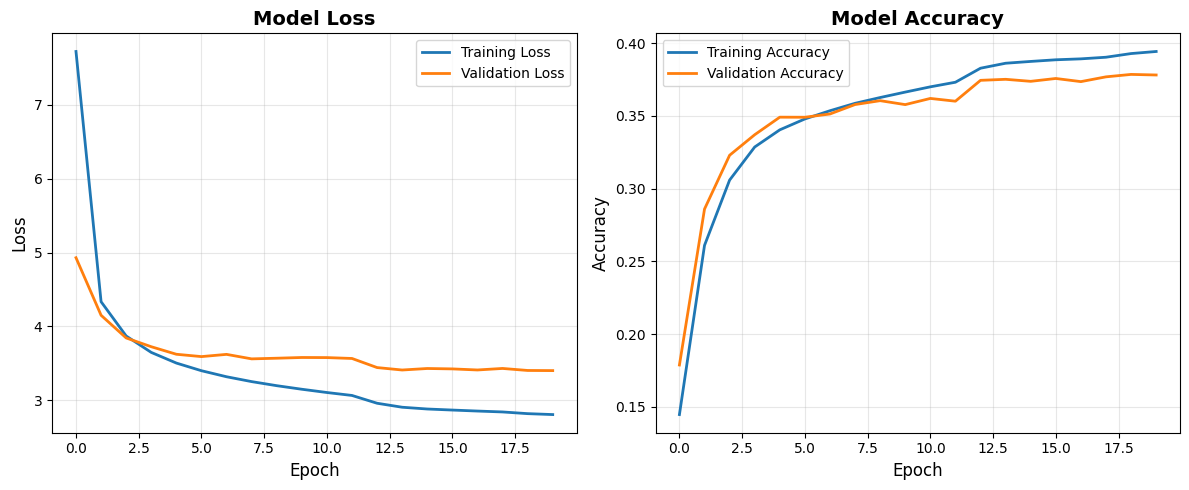

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5.2 Caption Generation Function

Generate captions for new images using greedy search or beam search.

In [ ]:
def generate_caption(model, image_features, tokenizer, max_length):

    # Start with <start> token
    caption = '<start>'

    for _ in range(max_length):
        # Tokenize current caption
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad sequence
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # Predict next word
        prediction = model.predict([image_features.reshape(1, 2048), sequence], verbose=0)
        predicted_index = np.argmax(prediction)

        # Convert index to word
        predicted_word = None
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break

        # Stop if <end> token is predicted or no word found
        if predicted_word is None or predicted_word == '<end>':
            break

        # Add word to caption
        caption += ' ' + predicted_word

    # Remove <start> token
    caption = caption.replace('<start>', '').strip()

    return caption

print("Caption generation function defined")

Caption generation function defined


## 5.3 Test Caption Generation

Generate captions for test images and compare with ground truth.


Image: 1339596997_8ac29c1841.jpg
Generated: a woman in a red dress and a white dress and a woman in a red dress end end of a crowd end end end end end end end end end end end end end end end
Ground Truth:
  - three females wearing head scarves standing together
  - three muslim women are looking at a camera


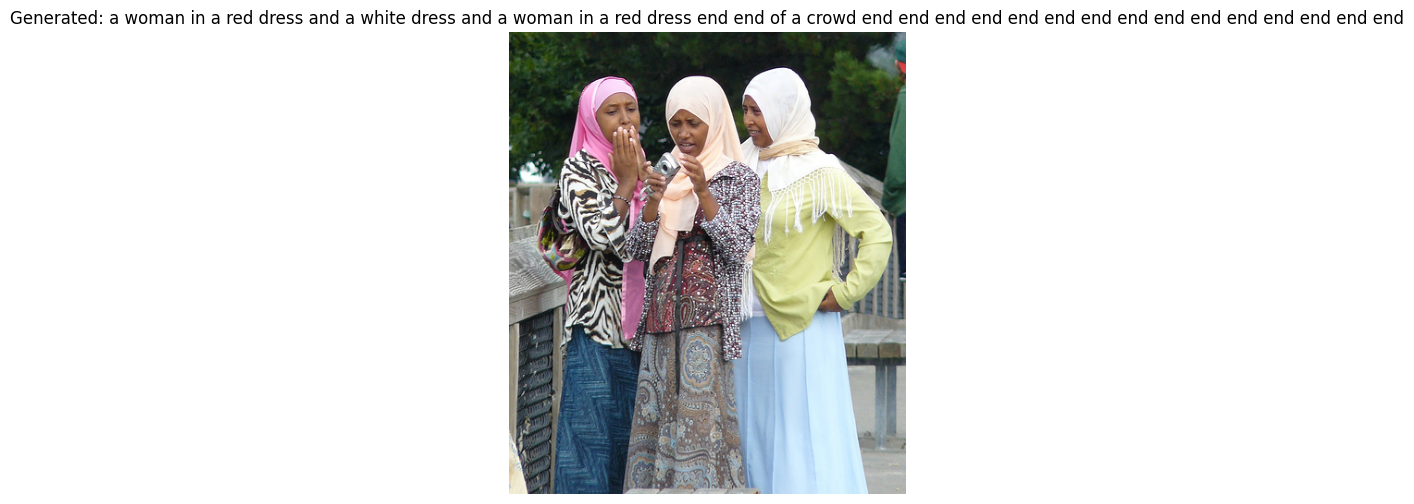

--------------------------------------------------------------------------------

Image: 2470486377_c3a39ccb7b.jpg
Generated: a man in a red shirt and a white shirt and a white shirt and a woman in a red shirt end of a man in a field end end end end end of a building end
Ground Truth:
  - a boy in a black shirt punches a yellow punching bag while a boy in a blue sweatshirt holds the bag
  - many children playing outside in the grass practicing punching


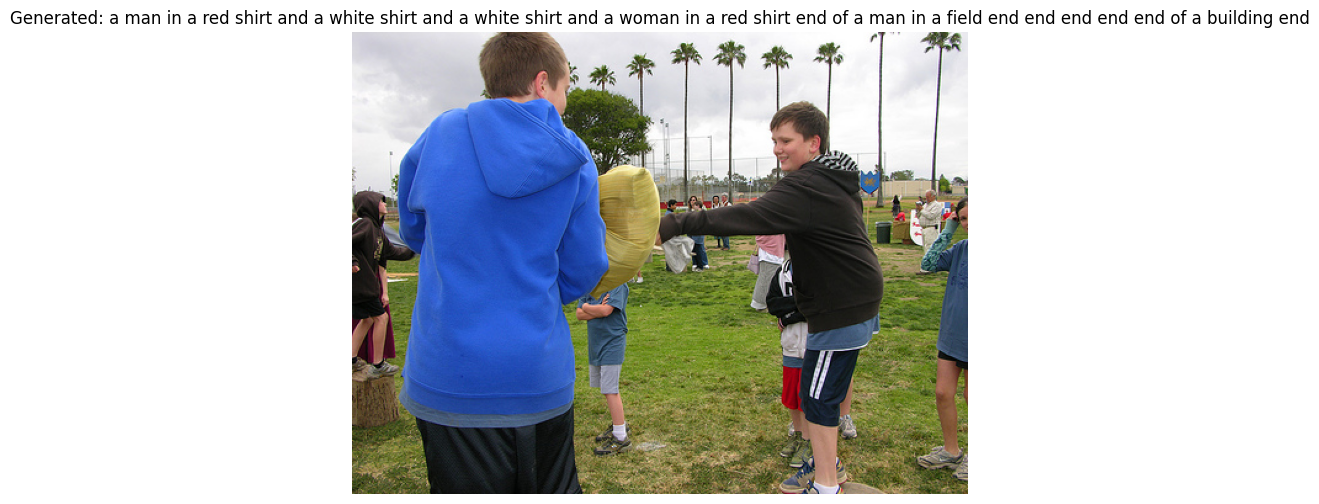

--------------------------------------------------------------------------------

Image: 106490881_5a2dd9b7bd.jpg
Generated: a boy in a blue shirt is running in the water end of the water end end end end end end end end end end end end end end end end end end end end end end
Ground Truth:
  - a boy in his blue swim shorts at the beach
  - a boy smiles for the camera at a beach


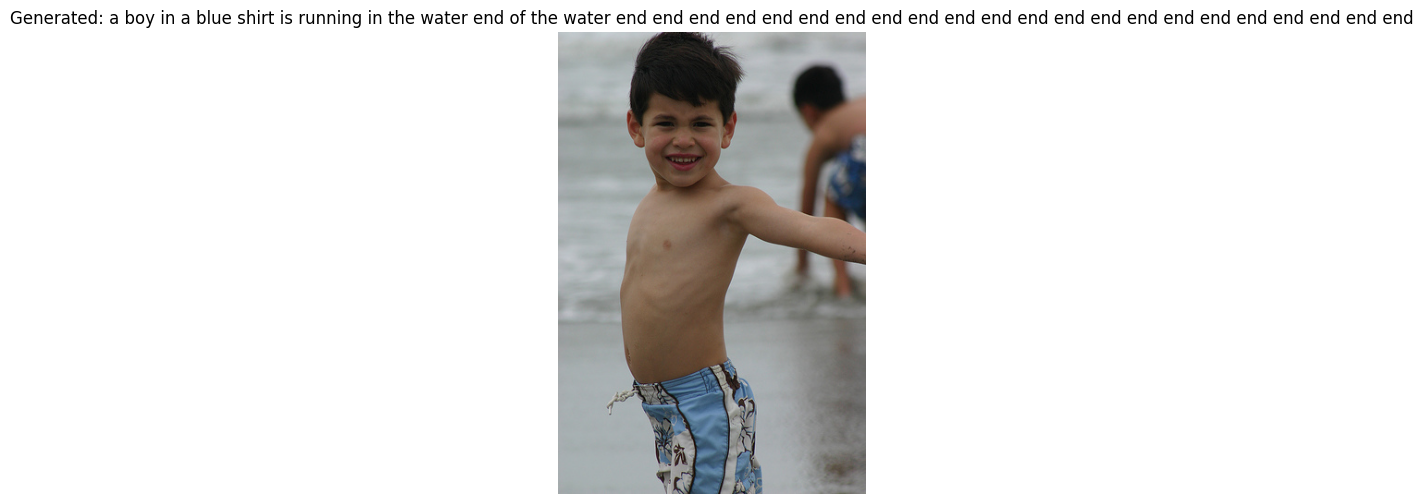

--------------------------------------------------------------------------------

Image: 2938120171_970564e3d8.jpg
Generated: a dog is running in the snow end of a fence end of a fence end end end of a fence end end end end end end end end end end end end end end end end
Ground Truth:
  - a large dog sniffing a smaller dog outside
  - two blond dogs are standing together on a patio


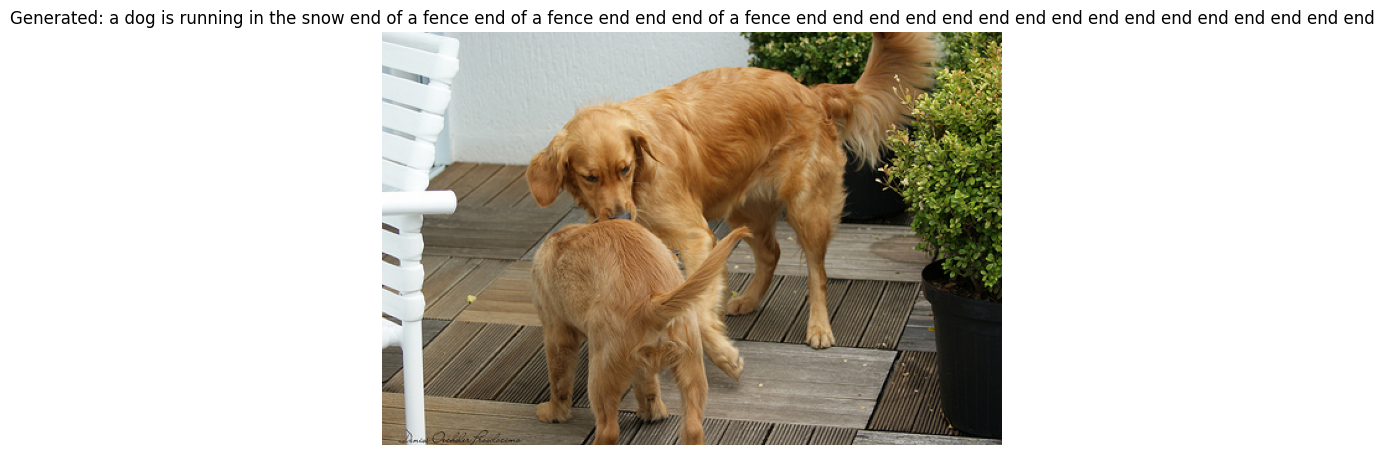

--------------------------------------------------------------------------------

Image: 544576742_283b65fa0d.jpg
Generated: a man in a red shirt climbs a rock climbing end of a rock end end end end end end end end end end end end end end end end end end end end end end end
Ground Truth:
  - a rock climber repels off a rocky wall
  - a woman climbing a rock cliff


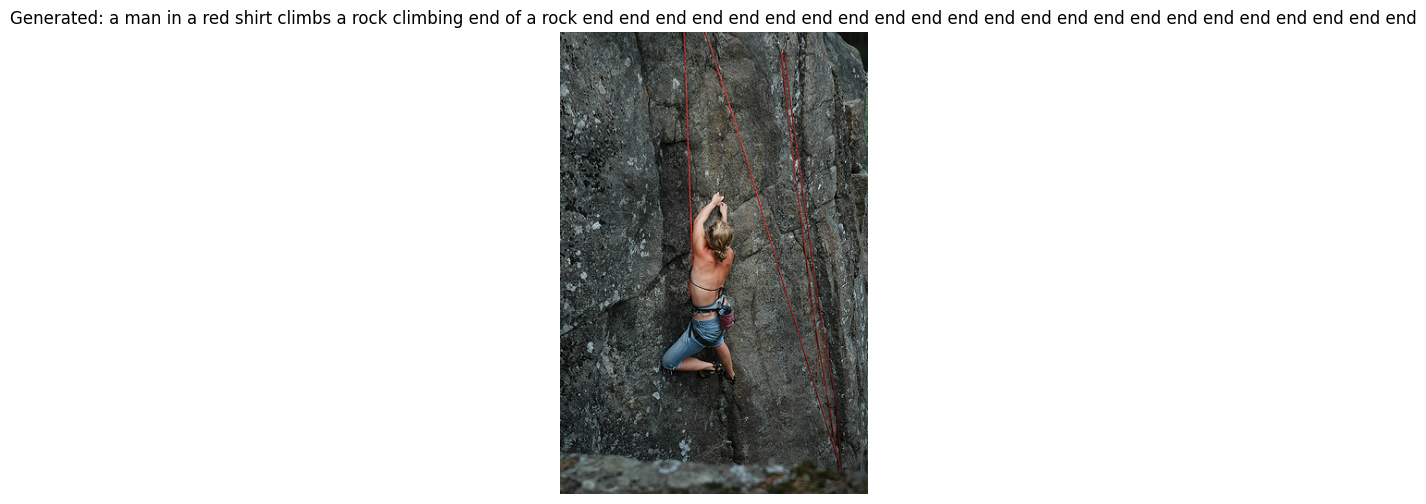

--------------------------------------------------------------------------------


In [ ]:
# Generate captions for a few test images
import random

num_samples = 5
sample_test_ids = random.sample(test_ids, num_samples)

for img_id in sample_test_ids:
    if img_id not in features_dict:
        continue

    # Get image features
    img_features = features_dict[img_id]

    # Generate caption
    generated_caption = generate_caption(caption_model, img_features, tokenizer, max_length)

    # Get ground truth captions
    gt_captions = cleaned_captions[img_id]

    # Display results
    print(f"\nImage: {img_id}")
    print(f"Generated: {generated_caption}")
    print(f"Ground Truth:")
    for cap in gt_captions[:2]:
        print(f"  - {cap.replace('<start>', '').replace('<end>', '').strip()}")

    # Display image
    img_path = os.path.join(IMAGES_PATH, img_id)
    img = plt.imread(img_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Generated: {generated_caption}", fontsize=12)
    plt.axis('off')
    plt.show()
    print("-" * 80)

## 5.4 Quantitative Evaluation: BLEU Score

We use the **BLEU (Bilingual Evaluation Understudy)** score to measure the quality of our generated captions against the reference captions.

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(model, descriptions, features, tokenizer, max_length):
    actual, predicted = list(), list()

    print("Generating predictions for evaluation...")

    # Step over the whole set
    for key, desc_list in tqdm(descriptions.items()):
        if key not in features:
            continue

        # Generate description
        img_feature = features[key]
        yhat = generate_caption(model, img_feature, tokenizer, max_length)

        # Clean up references
        references = [d.replace('<start>', '').replace('<end>', '').split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())

    # Calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

# Filter test descriptions
test_descriptions = {k: v for k, v in cleaned_captions.items() if k in test_ids}
evaluate_model(caption_model, test_descriptions, features_dict, tokenizer, max_length)

Generating predictions for evaluation...


100%|██████████| 1000/1000 [53:27<00:00,  3.21s/it]


BLEU-1: 0.198676
BLEU-2: 0.131241


## 5.5 Beam Search Decoding

**Beam Search** explores multiple possible caption paths simultaneously (Top-K) to find a globally better sentence than standard Greedy Search.

In [ ]:
print(list(tokenizer.word_index.keys())[:10])

['<unk>', 'a', 'end', 'start', 'in', 'the', 'on', 'is', 'and', 'dog']


Greedy: a brown dog is running in the snow end of a fence end end end end end end end end end end end end end end end end end end end end end end end end end
Beam Search (K=3): a brown dog is running in the snow of a fence


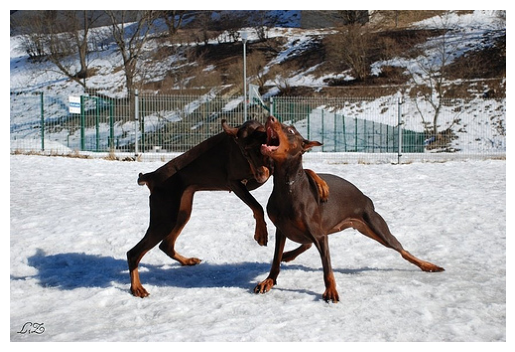

In [ ]:
def beam_search_predictions(model, image, tokenizer, max_length, beam_index=3):
    start = [tokenizer.word_index['start']]

    start_word = [[start, 0.0]]

    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image.reshape(1, 2048), par_caps], verbose=0)

            word_preds = np.argsort(preds[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        start_word = sorted(start_word, key=lambda l: l[1], reverse=True)
        start_word = start_word[:beam_index]

    best_seq = start_word[0][0]
    final_caption = []
    for i in best_seq:
        word = tokenizer.index_word.get(i)
        if word not in ['start', 'end', None]:
            final_caption.append(word)

    return ' '.join(final_caption)

sample_id = test_ids[0]
if sample_id in features_dict:
    print("Greedy:", generate_caption(caption_model, features_dict[sample_id], tokenizer, max_length))
    print("Beam Search (K=3):", beam_search_predictions(caption_model, features_dict[sample_id], tokenizer, max_length, beam_index=3))

    plt.imshow(plt.imread(os.path.join(IMAGES_PATH, sample_id)))
    plt.axis('off')
    plt.show()

## 5.6 Save Tokenizer and Configuration

In [ ]:
import pickle

# Save tokenizer
tokenizer_path = '/content/drive/MyDrive/tokenizer.pkl'
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)

# Save configuration
config = {
    'max_length': max_length,
    'vocab_size': vocab_size,
    'embedding_dim': EMBEDDING_DIM,
    'lstm_units': LSTM_UNITS
}

config_path = '/content/drive/MyDrive/model_config.pkl'
with open(config_path, 'wb') as f:
    pickle.dump(config, f)

print(f"Tokenizer saved to: {tokenizer_path}")
print(f"Config saved to: {config_path}")

Tokenizer saved to: /content/drive/MyDrive/tokenizer.pkl
Config saved to: /content/drive/MyDrive/model_config.pkl


---

# Project Summary

## Completed Tasks:

1. **Data Loading & Preprocessing**
   - Loaded 8,000 images from Flickr8k dataset
   - Parsed and cleaned 40,000 captions
   - Created vocabulary with tokenization
   - Split into train/val/test sets

2. **Feature Extraction**
   - Used InceptionV3 pre-trained model
   - Extracted 2048-dimensional feature vectors

3. **Model Architecture**
   - Encoder: InceptionV3 (CNN)
   - Decoder: LSTM with 512 units
   - Embedding dimension: 256
   - Dropout: 0.5 for regularization

4. **Training**
   - Trained using teacher forcing
   - Early stopping and model checkpointing
   - Saved best model to Google Drive

5. **Evaluation**
   - Generated captions for test images
   - Visualized training history
   - Implement BLEU score evaluation
   - Beam search for better caption generation

6. **Token-level Metrics Computation**
   - Computed precision, recall, F1, and exact-match accuracy
   - Saved detailed report to Google Drive


In [ ]:
# Paths to saved artifacts (adjust if different)
MODEL_PATH = '/content/drive/MyDrive/best_model.keras'
TOKENIZER_PATH = '/content/drive/MyDrive/tokenizer.pkl'
FEATURES_PATH = '/content/drive/MyDrive/image_features.pkl'
CONFIG_PATH = '/content/drive/MyDrive/model_config.pkl'
REPORT_MD = '/content/drive/MyDrive/caption_metrics_report_saved_model.md'

# Quick-eval settings: set QUICK_EVAL=True to evaluate only a random subset to save time
QUICK_EVAL = True
SAMPLE_SIZE = 500  
RANDOM_SEED = 42

start_time = time.time()

# Load model
if os.path.exists(MODEL_PATH):
    caption_model = load_model(MODEL_PATH)
    print(f"Loaded model from: {MODEL_PATH}")
else:
    raise FileNotFoundError(f"Saved model not found at: {MODEL_PATH}")

# Load tokenizer
if os.path.exists(TOKENIZER_PATH):
    with open(TOKENIZER_PATH, 'rb') as f:
        tokenizer = pickle.load(f)
    print(f"Loaded tokenizer from: {TOKENIZER_PATH}")
else:
    raise FileNotFoundError(f"Tokenizer not found at: {TOKENIZER_PATH}")

# Load features
if os.path.exists(FEATURES_PATH):
    with open(FEATURES_PATH, 'rb') as f:
        features_dict = pickle.load(f)
    print(f"Loaded image features from: {FEATURES_PATH} (images: {len(features_dict)})")
else:
    raise FileNotFoundError(f"Image features not found at: {FEATURES_PATH}")

# Load config (optional)
config = {}
if os.path.exists(CONFIG_PATH):
    with open(CONFIG_PATH, 'rb') as f:
        try:
            config = pickle.load(f)
            print(f"Loaded config from: {CONFIG_PATH}")
        except Exception:
            config = {}

# Use config values if available, fallback to sensible defaults
max_length = config.get('max_length', globals().get('max_length', 34))

# Define caption generator if not already defined
if 'generate_caption' not in globals():
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    def generate_caption(model, image_features, tokenizer, max_length):
        caption = '<start>'
        for _ in range(max_length):
            sequence = tokenizer.texts_to_sequences([caption])[0]
            sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
            prediction = model.predict([image_features.reshape(1, 2048), sequence], verbose=0)
            predicted_index = _np.argmax(prediction)
            predicted_word = tokenizer.index_word.get(predicted_index)
            if predicted_word is None or predicted_word == 'end':
                break
            caption += ' ' + predicted_word
        return caption.replace('<start>', '').strip()
    print('Defined local generate_caption function')

# Evaluation helper
def _compute_token_metrics(pred_tokens, ref_tokens):
    pred_set = set(pred_tokens)
    ref_set = set(ref_tokens)
    tp = len(pred_set & ref_set)
    precision = tp / len(pred_set) if len(pred_set) > 0 else 0.0
    recall = tp / len(ref_set) if len(ref_set) > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    return precision, recall, f1

# Prepare test IDs from saved split file if present, otherwise use keys from features
try:
    test_ids_local = globals().get('test_ids', None)
    if test_ids_local is None or len(test_ids_local) == 0:
        test_ids_local = list(features_dict.keys())
except Exception:
    test_ids_local = list(features_dict.keys())

# Prepare cleaned captions if present, otherwise try to load from captions file
cleaned_captions_local = globals().get('cleaned_captions', None)
if cleaned_captions_local is None:
    CAPTIONS_FILE = '/content/drive/MyDrive/Flicker8k_Dataset/Flickr8k_text/Flickr8k.token.txt'
    if os.path.exists(CAPTIONS_FILE):
        def load_captions(filepath):
            captions_dict = {}
            with open(filepath, 'r', encoding='utf-8') as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    parts = line.split('\t')
                    if len(parts) != 2:
                        continue
                    image_caption_id = parts[0]
                    caption = parts[1]
                    image_id = image_caption_id.split('#')[0]
                    captions_dict.setdefault(image_id, []).append(caption)
            return captions_dict
        raw_captions = load_captions(CAPTIONS_FILE)
        import re, string
        def clean_caption(caption):
            caption = caption.lower()
            caption = caption.translate(str.maketrans('', '', string.punctuation))
            caption = re.sub(r'\d+', '', caption)
            caption = ' '.join(caption.split())
            return '<start> ' + caption + ' <end>'
        cleaned_captions_local = {k: [clean_caption(c) for c in v] for k, v in raw_captions.items()}
        print('Loaded and cleaned captions from original captions file')
    else:
        raise FileNotFoundError('Cleaned captions not available in workspace; provide cleaned_captions or the original captions file.')

# Filter keys present in both features and captions
all_test_keys = [k for k in test_ids_local if k in features_dict and k in cleaned_captions_local]

# If quick eval requested, sample a subset to save time
if QUICK_EVAL:
    random.seed(RANDOM_SEED)
    if SAMPLE_SIZE < 1 or SAMPLE_SIZE >= len(all_test_keys):
        test_keys = all_test_keys
    else:
        test_keys = random.sample(all_test_keys, SAMPLE_SIZE)
    print(f"Quick-eval enabled: evaluating {len(test_keys)} / {len(all_test_keys)} images (sample)")
else:
    test_keys = all_test_keys
    print(f"Evaluating full set: {len(test_keys)} images")

# Run evaluation with progress bar
precisions = []
recalls = []
f1_scores = []
exact_match_count = 0
sample_results = []

for k in tqdm(test_keys, desc='Evaluating', unit='img'):
    refs = cleaned_captions_local[k]
    ref_tokens_all = []
    for r in refs:
        tokens = r.replace('<start>', '').replace('<end>', '').strip().split()
        ref_tokens_all.extend(tokens)
    ref_tokens_set = set(ref_tokens_all)

    pred = generate_caption(caption_model, features_dict[k], tokenizer, max_length)
    pred_tokens = pred.split()

    p, r_val, f = _compute_token_metrics(pred_tokens, ref_tokens_set)
    precisions.append(p)
    recalls.append(r_val)
    f1_scores.append(f)

    stripped_refs = [rr.replace('<start>','').replace('<end>','').strip() for rr in refs]
    if pred.strip() in stripped_refs:
        exact_match_count += 1

    if len(sample_results) < 10:
        sample_results.append((k, pred, stripped_refs[:3]))

# Aggregate results
avg_precision = float(_np.mean(precisions)) if precisions else 0.0
avg_recall = float(_np.mean(recalls)) if recalls else 0.0
avg_f1 = float(_np.mean(f1_scores)) if f1_scores else 0.0
accuracy = float(exact_match_count) / len(test_keys) if test_keys else 0.0

# Print
print('\nToken-level evaluation results (averaged across evaluated images):')
print(f"Precision: {avg_precision:.4f}")
print(f"Recall:    {avg_recall:.4f}")
print(f"F1-score:  {avg_f1:.4f}")
print(f"Accuracy (exact-match rate): {accuracy:.4f} ({exact_match_count}/{len(test_keys)})")

# Save report
with open(REPORT_MD, 'w', encoding='utf-8') as _f:
    _f.write('# Captioning Token-level Metrics Report (Saved Model)\n\n')
    _f.write(f'- Evaluated images: {len(test_keys)}\n')
    _f.write(f'- Precision (avg): {avg_precision:.4f}\n')
    _f.write(f'- Recall    (avg): {avg_recall:.4f}\n')
    _f.write(f'- F1-score  (avg): {avg_f1:.4f}\n')
    _f.write(f'- Accuracy (exact-match): {accuracy:.4f} ({exact_match_count}/{len(test_keys)})\n\n')
    _f.write('## Sample predictions (up to 10)\n')
    for sid, pred, rlist in sample_results:
        _f.write(f'- Image: {sid}\n')
        _f.write(f'  - Predicted: {pred}\n')
        _f.write('  - References:\n')
        for rr in rlist:
            _f.write(f'    - {rr}\n')
        _f.write('\n')

print(f"Saved report to: {REPORT_MD}")
print(f"Elapsed time: {time.time() - start_time:.1f} seconds")

Loaded model from: /content/drive/MyDrive/best_model.keras
Loaded tokenizer from: /content/drive/MyDrive/tokenizer.pkl
Loaded image features from: /content/drive/MyDrive/image_features.pkl (images: 8091)
Loaded config from: /content/drive/MyDrive/model_config.pkl
Loaded and cleaned captions from original captions file
Quick-eval enabled: evaluating 500 / 8091 images (sample)


Evaluating: 100%|██████████| 500/500 [08:17<00:00,  1.00img/s]


Token-level evaluation results (averaged across evaluated images):
Precision: 0.6856
Recall:    0.1980
F1-score:  0.3030
Accuracy (exact-match rate): 0.0020 (1/500)
Saved report to: /content/drive/MyDrive/caption_metrics_report_saved_model.md
Elapsed time: 498.4 seconds


---

# Project Summary

## Completed Tasks:

1. **Data Loading & Preprocessing**
   - Loaded 8,000 images from Flickr8k dataset
   - Parsed and cleaned 40,000 captions
   - Created vocabulary with tokenization
   - Split into train/val/test sets

2. **Feature Extraction**
   - Used InceptionV3 pre-trained model
   - Extracted 2048-dimensional feature vectors

3. **Model Architecture**
   - Encoder: InceptionV3 (CNN)
   - Decoder: LSTM with 512 units
   - Embedding dimension: 256
   - Dropout: 0.5 for regularization

4. **Training**
   - Trained using teacher forcing
   - Early stopping and model checkpointing
   - Saved best model to Google Drive

5. **Evaluation**
   - Generated captions for test images
   - Visualized training history
   - Implement BLEU score evaluation
   - Beam search for better caption generation
